## Flatiron DS111819 Module 1 Project - Kings County Property Price Modelling

# by Khairul Omar & Aleksandar Gakovic

## 1. Executive Summary

Text here

## 2. Data Import

In [207]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
%matplotlib inline

Load raw file into Pandas data frame and explore data

In [208]:
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


Note the list columns available in data frame:

## 3. Data Cleaning##

Start with checking that the data types are correct. In particular, columns that represent numerical values ought to have numerical data types.

In [209]:
df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront       float64
view             float64
condition          int64
grade              int64
sqft_above         int64
sqft_basement     object
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

Identify columns with null values:

In [210]:
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

Replace null values with zero, since the columns in question are numerical:

In [211]:
df['waterfront'] = df['waterfront'].fillna(0)
df['view'] = df['view'].fillna(0)
df['yr_renovated'] = df['yr_renovated'].fillna(0)

Check typical values of data for columns of interest. In addition, check for placeholder values (e.g. 0) which is not detected as null in the previous step.

In [212]:
for col in ['date', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view',
            'condition', 'grade', 'yr_built', 'yr_renovated', 'zipcode']:
    print(df[col].value_counts(normalize=True).head(3), '\n')

6/23/2014    0.006575
6/25/2014    0.006066
6/26/2014    0.006066
Name: date, dtype: float64 

3    0.454878
4    0.318655
2    0.127796
Name: bedrooms, dtype: float64 

2.50    0.248970
1.00    0.178312
1.75    0.141131
Name: bathrooms, dtype: float64 

1.0    0.494189
2.0    0.381303
1.5    0.088438
Name: floors, dtype: float64 

0.0    0.99324
1.0    0.00676
Name: waterfront, dtype: float64 

0.0    0.902209
2.0    0.044312
3.0    0.023522
Name: view, dtype: float64 

3    0.649164
4    0.262861
5    0.078761
Name: condition, dtype: float64 

7    0.415521
8    0.280826
9    0.121082
Name: grade, dtype: float64 

2014    0.025883
2006    0.020975
2005    0.020836
Name: yr_built, dtype: float64 

0.0       0.965551
2014.0    0.003380
2003.0    0.001435
Name: yr_renovated, dtype: float64 

98103    0.027874
98038    0.027272
98115    0.026994
Name: zipcode, dtype: float64 



Check the extent of extreme outliers that go beyond the general population of data, and remove them:

(array([1.9053e+04, 2.1180e+03, 2.9800e+02, 9.0000e+01, 2.6000e+01,
        4.0000e+00, 4.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([  78000.,  840200., 1602400., 2364600., 3126800., 3889000.,
        4651200., 5413400., 6175600., 6937800., 7700000.]),
 <a list of 10 Patch objects>)

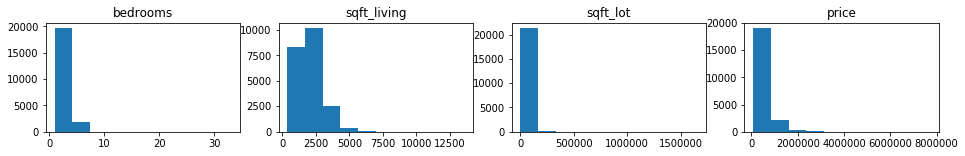

In [213]:
fig = plt.figure(figsize=(16,2))
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)
ax1.set_title('bedrooms')
ax2.set_title('sqft_living')
ax3.set_title('sqft_lot')
ax4.set_title('price')
ax1.hist(df.bedrooms)
ax2.hist(df.sqft_living)
ax3.hist(df.sqft_lot)
ax4.hist(df.price)

In [214]:
# Count number of extreme values to remove to make sure that we're not removing too many samples

ext1 = len(df.loc[df['bedrooms'] > 11])
ext2 = len(df.loc[df['sqft_living'] > 10000])
ext3 = len(df.loc[df['sqft_lot'] > 400000])
ext4 = len(df.loc[df['price'] > 4000000])
print(ext1, ext2, ext3, ext4)

# Remove extreme outliers

df.drop(df[df['bedrooms'] > 11].index, inplace = True)
df.drop(df[df['sqft_living'] > 10000].index, inplace = True)
df.drop(df[df['sqft_lot'] > 400000].index, inplace = True)
df.drop(df[df['price'] > 4000000].index, inplace = True)

1 3 43 11


## 4. EDA & Subsetting for Hypothesis

Display summary of key statistical measures on columns of interest to identify spread of values:

In [215]:
df1 = df[['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
          'condition', 'grade', 'yr_built', 'price']]
df1.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,price
count,21541.000000,21541.000000,21541.000000,21541.000000,21541.000000,21541.000000,21541.000000,21541.000000,2.154100e+04
mean,3.371013,2.112738,2074.916067,13876.318184,1.493524,3.409684,7.654055,1970.979342,5.372024e+05
std,0.902922,0.762377,900.651922,29040.002861,0.539668,0.650246,1.167018,29.373013,3.483440e+05
min,1.000000,0.500000,370.000000,520.000000,1.000000,1.000000,3.000000,1900.000000,7.800000e+04
25%,3.000000,1.750000,1420.000000,5040.000000,1.000000,3.000000,7.000000,1951.000000,3.210000e+05
50%,3.000000,2.250000,1910.000000,7603.000000,1.500000,3.000000,7.000000,1975.000000,4.500000e+05
75%,4.000000,2.500000,2550.000000,10625.000000,2.000000,4.000000,8.000000,1997.000000,6.428600e+05
max,11.000000,7.500000,8670.000000,392475.000000,3.500000,5.000000,13.000000,2015.000000,4.000000e+06


Plot scatter matrix on columns of interest to double check on their spread using histogram, and their correlation with other columns:

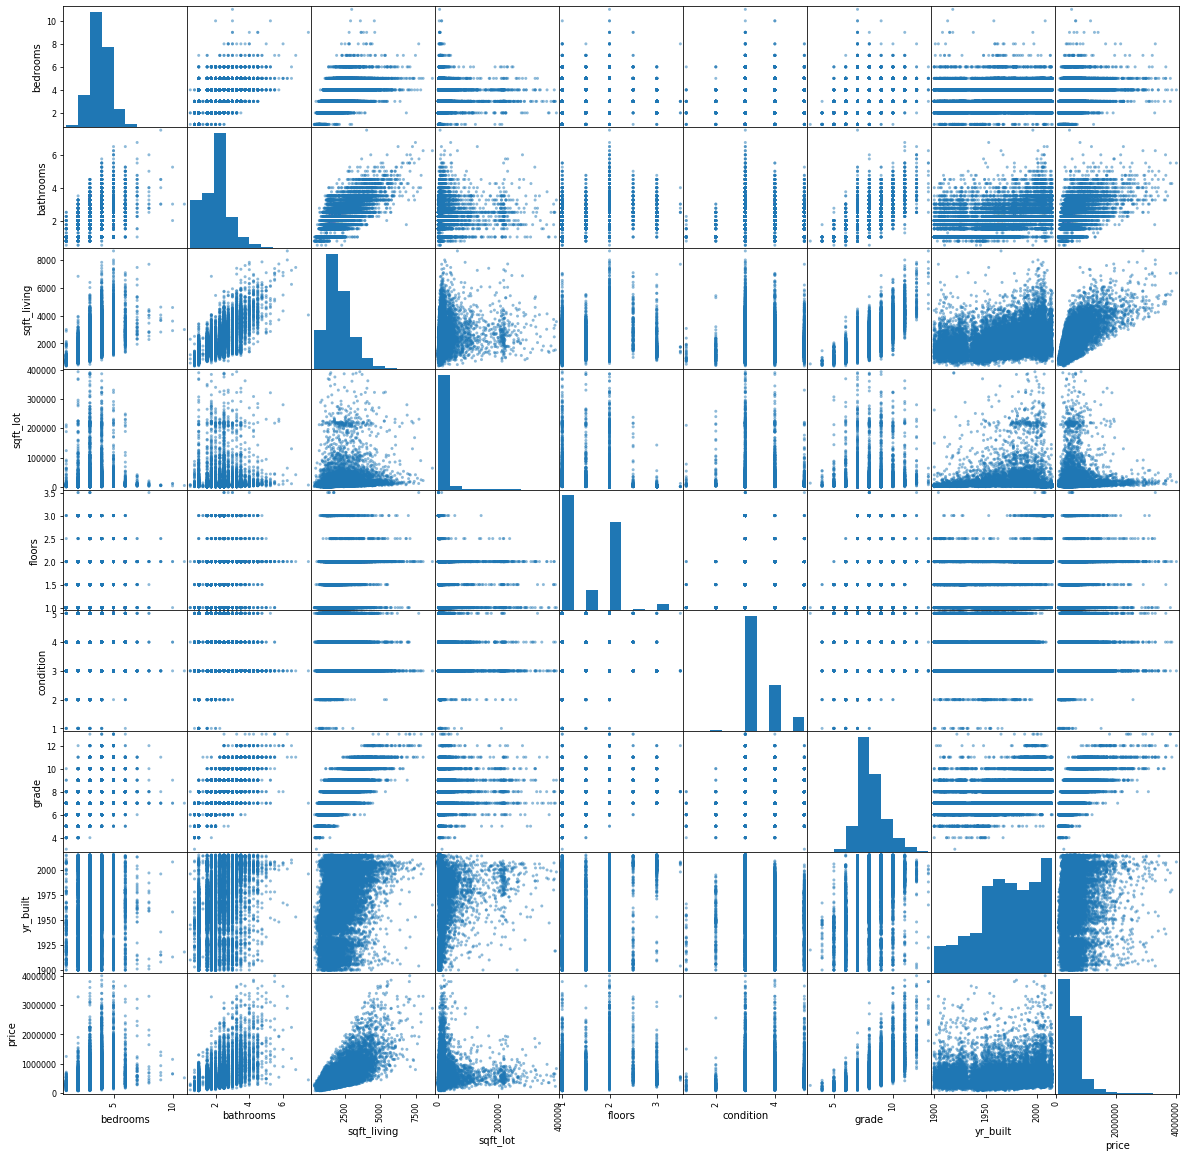

In [228]:
scatter = pd.plotting.scatter_matrix(df1, figsize=(20,20))

Notable conclusions from the summary table and matrix above:
- **sqft_living** has a good correlation with price and appears to have a fairly normal distribution, albeit slightlty skewed. This could be a prime candidate for the linear regression model.
- **sqft_lot** appears to be spread into 2 groups instead of a clear correlation with price, and does not correlate with sqft_living after a given lot size.
- **grade** also appears to have fairly good correlation with price. This is another good candidate for the model.

Calculate price per square feet from the available columns:

In [217]:
# New columns calculations:

df['price_per_sqft_lot'] = df['price']/df['sqft_lot']
df['price_per_sqft_living'] = df['price']/df['sqft_living']
df['sqft_outside'] = (df['sqft_lot'] - df['sqft_living']).astype(int)

Plot a heatmap of price per square feet to identify pattern of price range differences across the city.

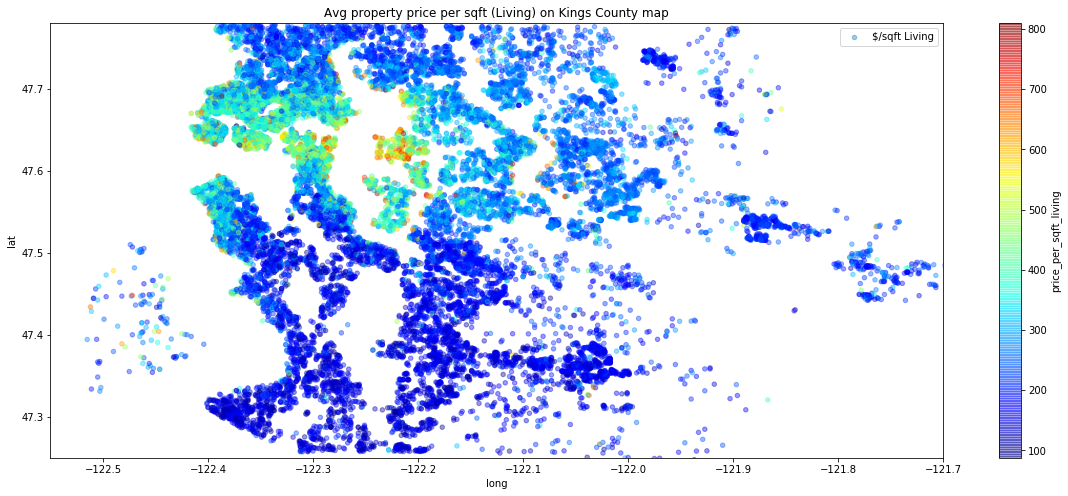

In [218]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot()
ax.set_title('Avg property price per sqft (Living) on Kings County map')
ax.set_ylim(47.25,47.78)
ax.set_xlim(-122.55,-121.70)

df.plot(kind="scatter", x="long", y="lat", label="$/sqft Living",
          c="price_per_sqft_living", cmap=plt.get_cmap("jet"),
          colorbar=True, alpha=0.4, ax=ax)

Notable conclusions from the heat map of price per square feet (living) for Kings Country:
- There is a distinct difference in price per square feet (living) between **different location** in the county. The expensive areas tend be in inner city areas, most likely explained by the proximity to jobs, education and public infrastructure whose data is not available in our dataset.
- **Waterfront** properties have significantly higher price per square feet (living), which can be explained by a better view and lifestyle.

While there is a clear differences between neighbourhood, we cannot use **zipcode** directly as a variable since they are categorical in nature and their numerical values do not correlate with price. Our strategy is to restate zipcode into **2 distinct categories: city and suburb**, based on the heat map and additional investigations below.

In order to have a clearer view of differences between different zipcodes, the plots below would assist us further in the classification.

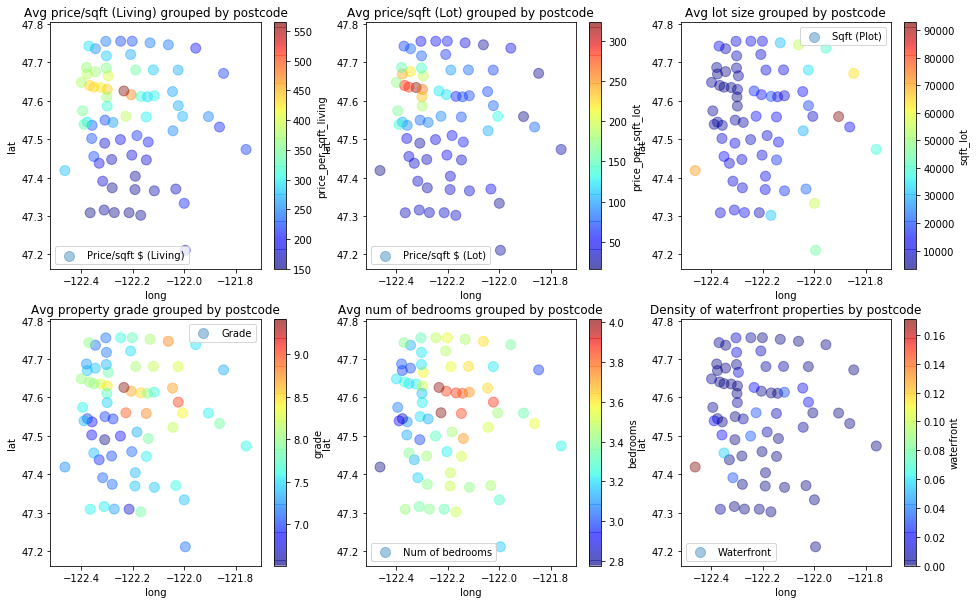

In [219]:
# Identify possible city vs suburb divide by looking at price/sqft and lot area split by zipcode

geo = df.groupby('zipcode').mean()

fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)
ax1.set_title('Avg price/sqft (Living) grouped by postcode')
ax2.set_title('Avg price/sqft (Lot) grouped by postcode')
ax3.set_title('Avg lot size grouped by postcode')
ax4.set_title('Avg property grade grouped by postcode')
ax5.set_title('Avg num of bedrooms grouped by postcode')
ax6.set_title('Density of waterfront properties by postcode')

geo.plot(kind="scatter", x="long", y="lat", label="Price/sqft $ (Living)",
          c="price_per_sqft_living", cmap=plt.get_cmap("jet"),
          colorbar=True, alpha=0.4, s=100, ax=ax1)

geo.plot(kind="scatter", x="long", y="lat", label="Price/sqft $ (Lot)",
          c="price_per_sqft_lot", cmap=plt.get_cmap("jet"),
          colorbar=True, alpha=0.4, s=100, ax=ax2)

geo.plot(kind="scatter", x="long", y="lat", label="Sqft (Plot)",
          c="sqft_lot", cmap=plt.get_cmap("jet"),
          colorbar=True, alpha=0.4, s=100, ax=ax3)

geo.plot(kind="scatter", x="long", y="lat", label="Grade",
          c="grade", cmap=plt.get_cmap("jet"),
          colorbar=True, alpha=0.4, s=100, ax=ax4)

geo.plot(kind="scatter", x="long", y="lat", label="Num of bedrooms",
          c="bedrooms", cmap=plt.get_cmap("jet"),
          colorbar=True, alpha=0.4, s=100, ax=ax5)

geo.plot(kind="scatter", x="long", y="lat", label="Waterfront",
          c="waterfront", cmap=plt.get_cmap("jet"),
          colorbar=True, alpha=0.4, s=100, ax=ax6)

Focusing primarily on the price per square feet (living), supported by other information available from 5 other plots above, we made an assumptions on which postcodes should be classify as **"city"** and which ones as **"suburb"**.

In [220]:
# Assumption of city zipcodes based on price per square ft and num of bedrooms

Seattle = [98199, 98119, 98109, 98102, 98112, 98122, 98144]
West_Seattle = [98116, 98136]
Medina = [98039, 98004]
Bellevue = [98005, 98006]
Fremont = [98107, 98117, 98103, 98105, 98115]
Mercer_Island = [98040]
Kirkland = [98033]

city_zipcodes_list = Seattle + West_Seattle + Medina + Bellevue + Mercer_Island + Kirkland + Fremont

# Turn into a dictionary, and then as data frame

city_zipcodes_dict = {}

for i in range(len(city_zipcodes_list)):
     city_zipcodes_dict[city_zipcodes_list[i]] = 2
        
d = {'zipcode': list(city_zipcodes_dict.keys()),'iscity': list(city_zipcodes_dict.values())}
city_zipcodes = pd.DataFrame(data=d)
city_zipcodes = city_zipcodes.set_index('zipcode')

Join the information of city zipcodes above with the main table so that all of our data can be categorized as either city or suburb.

In [221]:
# Add new field to mark city zipcode or suburb zipcode

df2 = df.join(city_zipcodes, how = 'left', on = 'zipcode')

# Replace iscity == NaN with 2 for Suburbs

df2['iscity'] = df2['iscity'].fillna(1)

# Proportion of city properties

print('{}% of properties are categorized as City'
       .format(round(len(df2.loc[df2['iscity']== 2]) / df2.shape[0] * 100,1)))

28.7% of properties are categorized as City


The distinction between city and suburb can be verified by looking at spread of price per square feet (including mean and quartile values). City properties price is around 50% higher than suburb (based on square feet living).

(0, 1000)

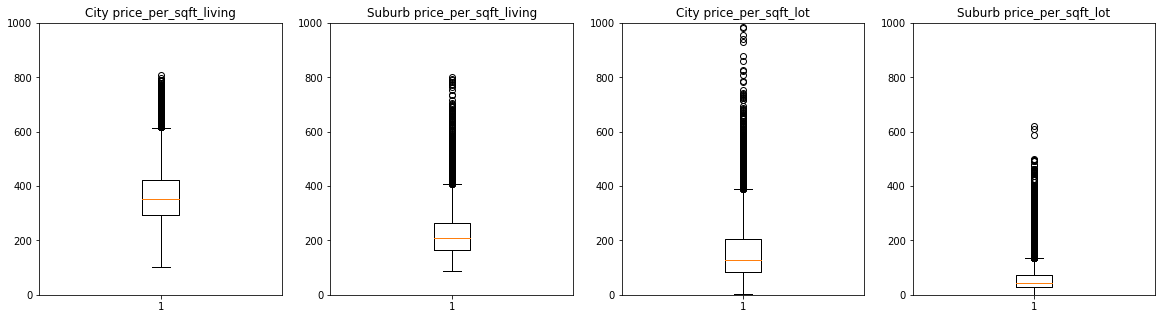

In [222]:
# Define city vs suburb subsets

city_df = df2.loc[df2['iscity']==2]
suburb_df = df2.loc[df2['iscity']==1]

# Investigating the spread of price between city and suburb

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

ax1.boxplot(city_df.price_per_sqft_living)
ax1.set_title('City price_per_sqft_living')
ax1.set_ylim(0,1000)

ax2.boxplot(suburb_df.price_per_sqft_living)
ax2.set_title('Suburb price_per_sqft_living')
ax2.set_ylim(0,1000)

ax3.boxplot(city_df.price_per_sqft_lot)
ax3.set_title('City price_per_sqft_lot')
ax3.set_ylim(0,1000)

ax4.boxplot(suburb_df.price_per_sqft_lot)
ax4.set_title('Suburb price_per_sqft_lot')
ax4.set_ylim(0,1000)

# 5. Modelling

As identified earlier, we noted that **sqft_living** would the primary candidate that drives the price. We can now run our first linear regression model using this as our initial single variable.

In [223]:
# Linear regression model based on sq ft living

# City locations only

cityliving = pd.DataFrame(city_df.sqft_living)
cityprice = pd.DataFrame(city_df.price)

model_skl = LinearRegression(fit_intercept=True)
model_skl.fit(cityliving,cityprice)

r21 = model_skl.score(cityliving,cityprice)
c1 = model_skl.intercept_
m1 = model_skl.coef_
print ('City properties: r2 = {}, intercept = {}, slope = {}'.format(r21.round(3), c1.round(0), m1.round(3)))

# Suburb locations only

suburbliving = pd.DataFrame(suburb_df.sqft_living)
suburbprice = pd.DataFrame(suburb_df.price)

model_skl = LinearRegression(fit_intercept=True)
model_skl.fit(suburbliving,suburbprice)

r22 = model_skl.score(suburbliving,suburbprice)
c2 = model_skl.intercept_
m2 = model_skl.coef_
print ('Suburb properties: r2 = {}, intercept = {}, slope = {}'.format(r22.round(3), c2.round(0), m2.round(3)))

# All locations

living = pd.DataFrame(df2.sqft_living)
price = pd.DataFrame(df2.price)

model_skl = LinearRegression(fit_intercept=True)
model_skl.fit(living,price)

r20 =model_skl.score(living,price)
c0 = model_skl.intercept_
m0 = model_skl.coef_
print ('All properties: r2 = {}, intercept = {}, slope = {}'.format(r20.round(3), c0.round(0), m0.round(3)))

City properties: r2 = 0.652, intercept = [10778.], slope = [[355.973]]
Suburb properties: r2 = 0.532, intercept = [11940.], slope = [[210.571]]
All properties: r2 = 0.482, intercept = [-20065.], slope = [[268.573]]


From the results above, we can see that grouping the data set into 2 categories yield better r2 value.
<br>
<br>
Below is the graphical representation of the regression above and the spread of property prices categorized by city and suburb.

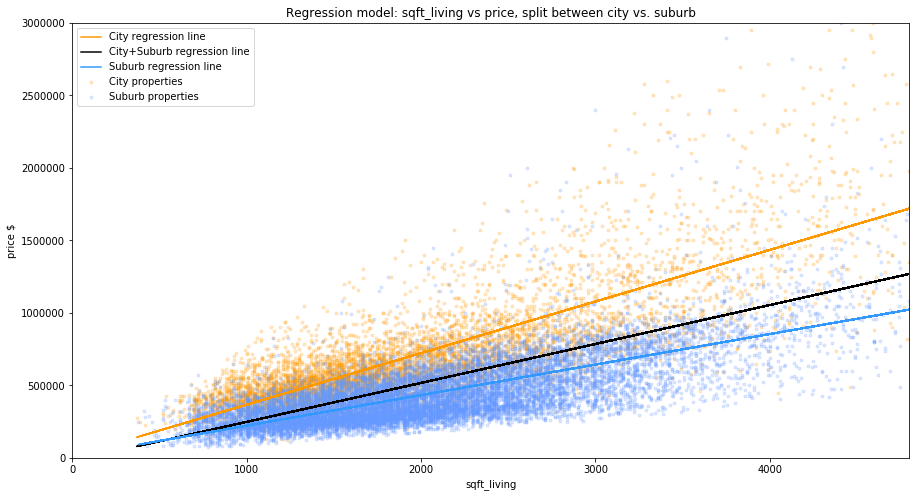

In [224]:
# Define regression lines for sqft_living model

def reg_line (m, c, xs):
    return [(m*x)+c for x in xs]

reg_line0 = reg_line(float(m0), float(c0), df2.sqft_living.tolist())
reg_line1 = reg_line(float(m1), float(c1), city_df.sqft_living.tolist())
reg_line2 = reg_line(float(m2), float(c2), suburb_df.sqft_living.tolist())

fig = plt.figure(figsize=(15,8))
ax  = plt.subplot()
ax.set_xlim(0,4800)
ax.set_ylim(0,3000000)

# Plot regression lines

plt.plot(city_df.sqft_living, reg_line1, color='#ff9900', label='City regression line')
plt.plot(df2.sqft_living, reg_line0, color='black', label='City+Suburb regression line')
plt.plot(suburb_df.sqft_living, reg_line2, color='#3399ff', label='Suburb regression line')

# Plot scatter, split between city and suburb

plt.scatter(city_df.sqft_living, city_df.price, color='#ff9900', marker='.', alpha=0.2, label='City properties')
plt.scatter(suburb_df.sqft_living, suburb_df.price, color='#6699ff', marker='.', alpha=0.2, label='Suburb properties')

plt.title('Regression model: sqft_living vs price, split between city vs. suburb')
plt.xlabel('sqft_living')
plt.ylabel('price $')
plt.legend()

Although there are some overlaps, we can also observe there are 2 distinct population of values (city and suburb). The regression lines when the two populations are split is also a better representation of their respective population.
<br>
<br>
We can finally proceed with running a multivariable regression model. Our choice of variables are as follows:
- **sqft_living**: as demonstrated in the single variable model.
- **iscity** (the newly created column): as we can see distinct correlation between the property location and price.
- **grade**: due to good correlation with price as seen in the scatter matrix.
- **waterfront**: from the heatmap, we can see that waterfront properties have significantly higher prices than their neighbours.

In [225]:
# Multivariable model

multivariables = ['sqft_living', 'iscity', 'waterfront', 'grade']
test_all = df2[multivariables]

model_skl = LinearRegression(fit_intercept=True, normalize=False, n_jobs=-1)
model_skl.fit(test_all, df2.price)

r2m0 = model_skl.score(test_all, df2.price)
cm0 = model_skl.intercept_
mm0 = model_skl.coef_

print('Single model for all properties:')
print('R2 = {}'.format(r2m0.round(2)))
print('Intersection: {}'.format(cm0.round(1)))
for i in range(len(multivariables)):
    print('Coeff{}: {} ({})'.format(i+1, mm0[i].round(1), multivariables[i]))



Single model for all properties:
R2 = 0.7
Intersection: -804237.2
Coeff1: 180.2 (sqft_living)
Coeff2: 286624.3 (iscity)
Coeff3: 821955.7 (waterfront)
Coeff4: 77512.1 (grade)


The results for our multivariable regression model is listed above.
<br>
<br>
Our model yields an **r2 value of 0.7**, and therefore we are fairly confident that we have a good model in hand.

In [226]:
# OLS regression results using Statsmodel

X = test_all
y = df2.price

X = sm.add_constant(X)
model_sm = sm.OLS(y,X)

results = model_sm.fit()
results.summary()

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                 1.269e+04
Date:                Mon, 02 Dec 2019   Prob (F-statistic):               0.00
Time:                        12:49:23   Log-Likelihood:            -2.9240e+05
No. Observations:               21541   AIC:                         5.848e+05
Df Residuals:                   21536   BIC:                         5.849e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -8.042e+05   1.04e+04    -77.557      0.000   -8.25e+05   -7.84e+05
sqft_living   180.2418      2.236     80.613      0.000     175.859     184.624
iscity       2.866e+05   2902.366     98.755      0.000    2.81e+05    2.92e+05
waterfront    8.22e+05   1.62e+04     50.767      0.000     7.9e+05    8.54e+05
grade        7.751e+04   1737.054     44.623      0.000    7.41e+04    8.09e+04
==============================================================================
Omnibus:                    12037.846   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           238321.255
Skew:                           2.275   Prob(JB):                         0.00
Kurtosis:                      18.647   Cond. No.                     2.83e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.83e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Upon checking the colinearity between the variables used in the model, we can confirm that one of the variables correlate strongly with each other.

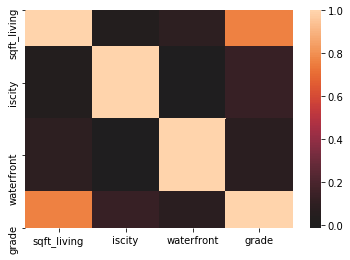

In [227]:
# Rechecking that variables in multilinear model don't correlate with each other

test_all.corr()
sns.heatmap(test_all.corr(), center=0)

## 6. Conclusions

Text